
# **FINAL PROJECT PHASE II**



# Primary Research Question:
Can we build an early warning model that predicts in-hospital cardiac arrest in sepsis patients up to 6 hours before the event using routinely collected EHR features (vital signs and labs)?

**Secondary Research Questions:**
Which types of features (static demographics, recent vitals, time-series trends) appear most predictive in initial exploratory analysis?

Are there obvious data quality or sampling issues (missingness, irregular sampling) that will meaningfully change modeling choices?

#Importing


In [ ]:
# imports and settings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from google.colab import files
uploaded = files.upload()

#from google.colab import drive
#drive.mount('/content/drive')


Saving ICUSTAYS.csv to ICUSTAYS (1).csv


#Data Overview



*This statement applies for all three data sets given that they all come from the MIMIC III database*: The availability for this data is limited to researchers who are approved after completing a recognized course and after signing a data use agreement.

https://physionet.org/content/mimiciii/1.4/


The MIMIC III database is a large, freely-avaliable databse comprising deidentified health-related data associated with 40,000 patients who stayed in critical care units of Beth Israel Deaconess Medical Center between 2001 and 2012. The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), lab test results, procedurs, medications, caregiver notes, imaging reports, and mortality.

The ADMISSION.csv has important information including the diagnosis for admission, the patient’s ethnicity, and the type of admission (i.e. elected or emergency). This dataset includes over 58,000 rows of data, of which there are an estimated 45620 unique patient admissions.

The ICUSTAYS.csv lists the length of stay(s) or “LOS” for each patient in hours. Again the subject ID is provided along with the ICUSTAY_ID.

TRANSFERS.csv also lists the length of stay(s) or “LOS” for each patient in hours. However, these patients are transferred from a different healthcare facility or between different units or levels of care within the same facility.

In [ ]:
df_adm=pd.read_csv('ADMISSIONS.csv')
df_icu=pd.read_csv('ICUSTAYS.csv')
df_transf=pd.read_csv('TRANSFERS.csv')

In [ ]:
print(df_adm.columns,'\n',df_icu.columns, '\n', df_transf.columns)


Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object') 
 Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS'],
      dtype='object') 
 Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'EVENTTYPE', 'PREV_CAREUNIT', 'CURR_CAREUNIT', 'PREV_WARDID',
       'CURR_WARDID', 'INTIME', 'OUTTIME', 'LOS'],
      dtype='object')


# Data Collection and Cleaning

Below are the columns for each of the csv files. We will begin by removing columns of each csv that we will not use in our analysis.

TRANSFERS: "ROW_ID","SUBJECT_ID","HADM_ID","ICUSTAY_ID","DBSOURCE","EVENTTYPE","PREV_CAREUNIT","CURR_CAREUNIT","PREV_WARDID","CURR_WARDID","INTIME","OUTTIME","LOS"


ICU STAYS
"ROW_ID","SUBJECT_ID","HADM_ID","ICUSTAY_ID","DBSOURCE","FIRST_CAREUNIT","LAST_CAREUNIT","FIRST_WARDID","LAST_WARDID","INTIME","OUTTIME","LOS"

ADMISSIONS:
"ROW_ID","SUBJECT_ID","HADM_ID","ADMITTIME","DISCHTIME","DEATHTIME","ADMISSION_TYPE","ADMISSION_LOCATION","DISCHARGE_LOCATION","INSURANCE","LANGUAGE","RELIGION","MARITAL_STATUS","ETHNICITY","EDREGTIME","EDOUTTIME","DIAGNOSIS","HOSPITAL_EXPIRE_FLAG","HAS_CHARTEVENTS_DATA"

From the **transfers.csv**, we will remove [ROW_ID, DBSOURCE, PREV_CAREUNIT, PREV_WARID, CURR_WARDID].

From the **icustays.csv**, we will remove [ROW_ID,DBSOURCE,FIRST_CAREUNIT,FIRST_WARDID,LAST_WARDID].

From the **admission.csv**, we will remove [ROW_ID,ADMISSION_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,EDREGTIME,EDOUTTIME,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA].


In [ ]:
throwaway_cols_transf=[
"ROW_ID","DBSOURCE", "PREV_CAREUNIT","PREV_WARDID","CURR_WARDID"
]
df_transf.drop(columns=throwaway_cols_transf,axis=1,inplace=True)


throwaway_cols_icu=[
"ROW_ID","DBSOURCE","FIRST_CAREUNIT",
                    "FIRST_WARDID","LAST_WARDID"
]
df_icu.drop(columns=throwaway_cols_icu,axis=1,inplace=True)

throwaway_cols_adm=[
"ROW_ID","ADMISSION_LOCATION","DISCHARGE_LOCATION",
                     "INSURANCE","LANGUAGE","RELIGION","MARITAL_STATUS",
                      "EDREGTIME","EDOUTTIME"
                     ,"HOSPITAL_EXPIRE_FLAG","HAS_CHARTEVENTS_DATA"
]
df_adm.drop(columns=throwaway_cols_adm,axis=1,inplace=True)


This code loads the 3 tables and merges them to create a unified dataset linking each ICU stay with hospital-level admission details and current care unit information.

In [ ]:

adm = pd.read_csv('ADMISSIONS.csv', parse_dates=['ADMITTIME', 'DISCHTIME', 'DEATHTIME'])
icu = pd.read_csv('ICUSTAYS.csv', parse_dates=['INTIME', 'OUTTIME'])
trans = pd.read_csv('TRANSFERS.csv', parse_dates=['INTIME', 'OUTTIME'])

# Merge ICU stays with admission-level info
merged = icu.merge(adm, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# Optionally add transfers for care unit trajectory
merged = merged.merge(trans[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CURR_CAREUNIT']],
                      on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'], how='left')


Now we want to isolate the sepsis and cardiac arrest patients from all the different patients with different diagnoses (as we are searching for trends of sepsis patients in identifying cardiac arrest).

In [ ]:
sepsis_df = merged[merged['DIAGNOSIS'].str.contains('SEPSIS', case=False, na=False)]
print("Sepsis patients:", len(sepsis_df))

arrest_df = merged[merged['DIAGNOSIS'].str.contains('CARDIAC ARREST', case=False, na=False)]
print("Cardiac arrest patients:", len(arrest_df))

Sepsis patients: 2516
Cardiac arrest patients: 377


It is important to note that arrest_df only captures patients admitted for cardiac arrest - **not those who had a cardiac arrest later**.

After this step we filter the sepsis and arrest patients and group them into a cohort.

In [ ]:
merged['IS_SEPSIS'] = merged['DIAGNOSIS'].str.contains('SEPSIS', case=False, na=False)
merged['IS_ARREST'] = merged['DIAGNOSIS'].str.contains('CARDIAC ARREST', case=False, na=False)

cohort = merged[(merged['IS_SEPSIS'] == True) | (merged['IS_ARREST'] == True)]
print("Combined sepsis/cardiac arrest cohort size:", len(cohort))


Combined sepsis/cardiac arrest cohort size: 2893



# Data description

**What are the observations (rows) and the attributes (columns)?**


Column (all unique columns from transfers.csv, icustays.csv, & admission.csv)

* **ADMISSION_LOCATION:** Where the patient was immediately before hospital admission (e.g., “TRANSFER FROM HOSPITAL,” “EMERGENCY ROOM”).
* **ADMISSION_TYPE:** Category of admission such as “ELECTIVE,” “EMERGENCY,” or “URGENT.”
* **ADMITTIME:** Date and time the patient was admitted to the hospital.
* **CURR_CAREUNIT:** The ICU care unit the patient is currently located in for that transfer record.
* **CURR_WARDID:** Numeric identifier for the ward the patient is currently assigned to.
* **DBSOURCE:** Indicates whether the record came from the CareVue or MetaVision database system.
* **DEATHTIME:** Timestamp of death if the patient died during the hospital stay; otherwise blank.
* **DIAGNOSIS:** Primary admission diagnosis text recorded by hospital staff.
* **DISCHARGE_LOCATION:** Where the patient went after discharge (e.g., “HOME,” “REHAB,” “SNF”).
* **DISCHTIME:** Date and time the patient was discharged from the hospital.
* **EDOUTTIME:** Time the patient left the emergency department, if applicable.
* **EDREGTIME:** Time the patient was first registered or arrived in the emergency department.
* **ETHNICITY:** Patient’s recorded ethnicity as entered in the hospital system.
* **EVENTTYPE:** Type of transfer event (e.g., “admit,” “transfer,” or “discharge”) within the hospital.
* **FIRST_CAREUNIT:** The first ICU care unit where the patient was admitted during the ICU stay.
* **FIRST_WARDID:** Numeric identifier for the ward corresponding to the first ICU location.
* **HAS_CHARTEVENTS_DATA:** Binary flag (1/0) indicating whether charted time-series data exist for the hospital admission.
* **HADM_ID:** Unique integer identifying a single hospital admission (linkable across tables).
* **HOSPITAL_EXPIRE_FLAG:** 1 if the patient died during the hospital stay, 0 otherwise.
* **ICUSTAY_ID:** Unique integer identifying one ICU stay; a hospital admission can have multiple ICU stays.
* **INSURANCE:** Patient’s insurance category (e.g., “Medicare,” “Private,” “Self Pay”).
* **INTIME:** Time the patient entered the ICU or care unit.
* **LANGUAGE:** Primary language recorded for the patient.
* **LAST_CAREUNIT:** ICU care unit where the patient was located at the end of the ICU stay.
* **LAST_WARDID:** Numeric identifier for the ward associated with the last ICU location.
* **LOS:** Length of stay, typically in days, calculated from INTIME and OUTTIME.
* **MARITAL_STATUS:** Patient’s marital status (e.g., “MARRIED,” “SINGLE”).
* **OUTTIME:** Time the patient left the ICU or care unit.
* **PREV_CAREUNIT:** The previous ICU care unit before the current transfer (used in TRANSFERS).
* **PREV_WARDID:** Numeric identifier for the ward the patient was in before the current transfer.
* **RELIGION:** Patient’s self-reported religion recorded at admission.
* **ROW_ID:** Internal numeric key used by the database to uniquely identify each row.
* **SUBJECT_ID:** Unique patient identifier that links all of a patient’s admissions and stays across tables.



**Who funded the creation of the dataset?**

This research and development was supported by grants NIH-R01-EB017205, NIH-R01-EB001659, and NIH-R01-GM104987 from the National Institutes of Health.

**Why was this dataset created?**


The data set was created to address the challenge of interoperability and reproducibility. Because hospital digital systems often cannot share or integrate data effectively, valuable clinical information remains underused. A standardized dataset helps overcome this by providing a common and practical structure for hospital data, enabling intergration and analysis across systems. Additionally, the scientific community's reproducibility crisis means that many studies cannot be reliably repeated due to inconsistent or inaccessible data. The dataset was therefore created to promote transparency and reproducibility in health data research but offering a curated and accessible source of data

**What processes might have influenced what data was observed and recorded and what was not?**

1. Routine clinical care vs research-driven recording

The dataset was collected during routine hospital care, not for the primary purpose of research. Becuase of this, clinical priorities drive what gets recorded. Therefore, the dataset is biased toward what clinicians and hospital systems deem relevant to care rather than providing everything about the patient.

2. Workflow and human factors

Measurements (vitals, labs) often depend on nurse/clinician documentation, device-reading, and therefore are subject to timing, missingness and accuracy. The recorded data reflects the clinical context rather than an ideal systematic measurement plan.



**What preprocessing was done, and how did the data come to be in the form that you are using?**

1. Data Sources

ICU patient care data from two distinct crtical care information systems: Philips CareVue Clinical Information System and iMDsoftMetaVision ICU. Hospital EHR databases capturing: patient demographics, admissions & discharges, hospital-wide labs, billing and diagnostic codes. Mortality information from the Social Security Administration Death Master File for out-of-hospital deaths.

2. De-identification and Privacy Measures

Removed all HIPAA indentifiers (name, address, phone number). For each patient, a consistent random offset was applied so that real calendar dates are obscure but relative intervals are preserved. For patients aged 89+ years old, the date of birth was shifted to make them appear with ages 300+ years old to meet de-identification requirements.

3. Harmonisation & Integration of Multiple Systems

Data from CareVue and MetaVision were merged where possible. For events that couldn't be harmonised, seperate tables were maintained (INPUTEVENTS_CV for CareVue vs INPUTEVENTS_MV for MetaVision). Standardisation of coding systems: lab test ITEMIDs, diagnosis ICD-9 codes, procedure codes (CPT/ICD9), dictionary tables. Filtering out implausible data.

4. Creation of Relational Schema & Tabular Format

Data were stored as a relational database comprising 26 tables. Files are distributed as CSV files and can be imported into database systems.

5. Time-alignment

Timestamps were preserved in relative terms but the absolute calendar year is shifted/disguised.

**If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?**

Because consent was waived and data was collected as part of routine care, it is very unlikely that each patient was explicitly informed that their data would later be used in this research database. From the project side, the expectation was that by de-identifying the data and obtaining IRB approval with the waiver of consent, the data could ethically be reused for research.

**Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted on Github, in a Cornell Google Drive or Cornell Box).**

https://drive.google.com/drive/folders/1rq6y9N0SfmCdcdtScZgLLa-2HXAPIVFn?usp=sharing

**Citation of Database**

Johnson, Alistair, et al. *“MIMIC-III Clinical Database” (version 1.4).* PhysioNet, 2016. [https://doi.org/10.13026/C2XW26](https://doi.org/10.13026/C2XW26). ([physionet.org][1])

[1]: https://physionet.org/content/mimiciii/1.4/?utm_source=chatgpt.com "MIMIC-III Clinical Database v1.4 - PhysioNet"



#Data limitations

There are a **few key limitations** for our data:

1. Single-centre

MIMIC-III covers patients from one hospital, Beth Israel Deaconess Medical Center in Boston, MA and only in its ICU units. Our findings may not generalise to other hospitals, general wards or less acute settings.

2. Time and system drift/measurement changes

MIMIC-III covers 2001-2012 during which two different ICU information systems were used. As highlighted, clinical data in MIMIC-III suffers from non-stationary (changes over time, system changes inpact measurement). If we assume measurements are uniformly collected and comparable across the time span, you may face bias (different sampling frequencies or doccumentation practices acorss epochs).

3. Missingness, irregular sampling, and clinical measurement bias

Because data was collected as part of routine care, the data faces missing vital signs or labs when clinically not indicated and irregular sampling and thus your routine features are subject to informative missingness and selection bias in what is measured.

4.   Incomplete dataset/primary research question interpretation

Our original research question asks about predicting cardiac arrest during hospitalization for sepsis patients. However, our current data only shows admission diagnosis, not in-hospital events.
We'll need additional data (like the CHARTEVENTS or NOTEEVENTS tables from MIMIC-III) to identify:

When cardiac arrests occurred during the stay
The 6-hour lead time window we want to predict
Vital signs and labs leading up to the event

The current analysis compares patients admitted FOR cardiac arrest vs admitted FOR sepsis, which isn't quite our research question.

#Exploratory data analysis

This is a non-exhaustive list of the above cohort summary statistics which include:
*   Number of unique patients, admissions, and ICU stays

*   Average length of stay (LOS)

*   Distribution of admission types (Emergency, Elective, etc.)

*   Ethnicity or age group breakdown (if age available)

*   Mortality rate (using DEATHTIME if not null)









In [ ]:
print(f"Unique patients: {cohort['SUBJECT_ID']}.nunique()")
print(f"Unique admissions: {cohort['HADM_ID']}.nunique()")
print(f"Unique ICU stays: {cohort['ICUSTAY_ID']}.nunique()")

print(f"Average LOS (days): {cohort['LOS']}.mean()")

print("\nAdmission types:")
print(cohort['ADMISSION_TYPE'].value_counts(normalize=True))

print("\nEthnicity distribution:")
print(cohort['ETHNICITY'].value_counts().head(10))



Unique patients: 1          269
8          275
89         323
136        353
137        353
         ...  
87631    91934
87638    91951
87654    92003
87683    94864
87714    94937
Name: SUBJECT_ID, Length: 2893, dtype: int64.nunique()
Unique admissions: 1        106296
8        129886
89       143334
136      108923
137      112976
          ...  
87631    155290
87638    106173
87654    193800
87683    168788
87714    156213
Name: HADM_ID, Length: 2893, dtype: int64.nunique()
Unique ICU stays: 1        206613
8        219649
89       264375
136      224409
137      208489
          ...  
87631    223146
87638    246330
87654    278536
87683    288166
87714    293838
Name: ICUSTAY_ID, Length: 2893, dtype: int64.nunique()
Average LOS (days): 1         3.2788
8         7.1314
89        3.0252
136       0.9663
137       3.6969
          ...   
87631    10.7607
87638     0.9305
87654     1.0586
87683     8.0249
87714     1.1919
Name: LOS, Length: 2893, dtype: float64.mean()

Admission ty

Here we have a visual that shows the distribution of the length of stay times for sepsis and cardiac arrest patients. This plot may help us infer how the severity of a sepsis case per patient correlates to their length of stay in the hospital.

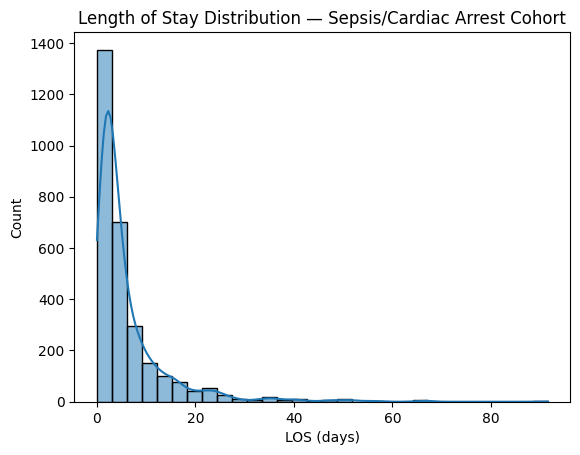

In [ ]:
sns.histplot(cohort['LOS'], bins=30, kde=True)
plt.title("Length of Stay Distribution — Sepsis/Cardiac Arrest Cohort")
plt.xlabel("LOS (days)")
plt.ylabel("Count")
plt.show()

Out of the cohort we can separate the data into subgroups to see the different LOSs between sepsis patients and cardiac arrest patients.

The subgroups being **sepsis_only** and **arrest_only**.



Avg LOS - Sepsis only: 6.131843282988871
Avg LOS - Patients with Arrest: 5.90382572944297

Sepsis only count: 2516
Arrest patients count: 377


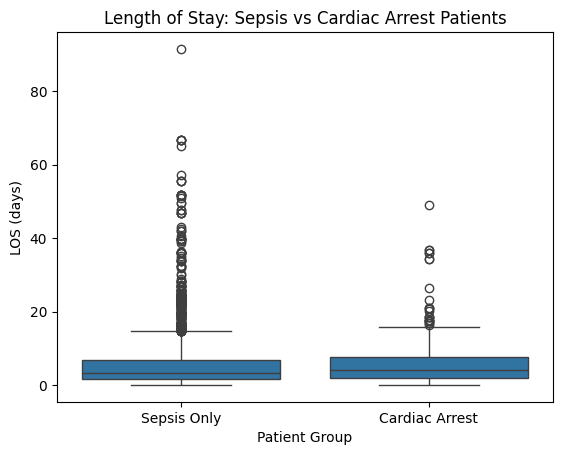

In [ ]:
# Your cohort already contains both sepsis and arrest patients
sepsis_only = cohort[~cohort['IS_ARREST']]  # Sepsis patients without arrest in diagnosis
sepsis_with_arrest = cohort[cohort['IS_ARREST']]  # Patients with arrest in diagnosis

print("Avg LOS - Sepsis only:", sepsis_only['LOS'].mean())
print("Avg LOS - Patients with Arrest:", sepsis_with_arrest['LOS'].mean())
print(f"\nSepsis only count: {len(sepsis_only)}")
print(f"Arrest patients count: {len(sepsis_with_arrest)}")

# Create combined dataframe for boxplot
plot_data = pd.concat([
    sepsis_only.assign(Group='Sepsis Only'),
    sepsis_with_arrest.assign(Group='Cardiac Arrest')
])

sns.boxplot(x='Group', y='LOS', data=plot_data)
plt.title("Length of Stay: Sepsis vs Cardiac Arrest Patients")
plt.xlabel("Patient Group")
plt.ylabel("LOS (days)")
plt.show()

The chart shows the distribution of hospital admissions by hour, with admissions peaking in the late afternoon and evening and fewer patients admitted during early morning hours.

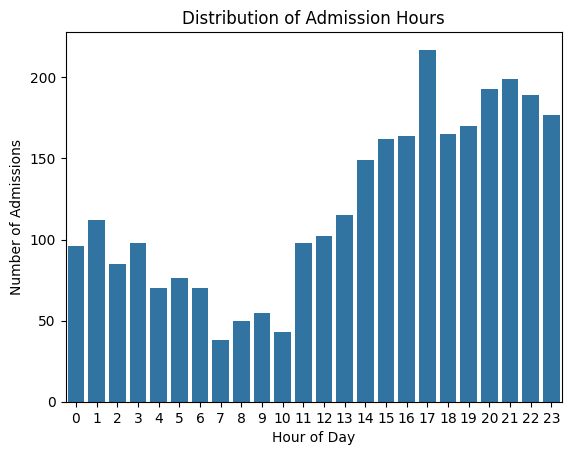

In [ ]:
cohort = cohort.copy()
cohort['admit_hour'] = pd.to_datetime(cohort['ADMITTIME']).dt.hour
sns.countplot(x='admit_hour', data=cohort)
plt.title("Distribution of Admission Hours")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Admissions")
plt.show()

This section here gives some insight on the data quality as well as missing values.


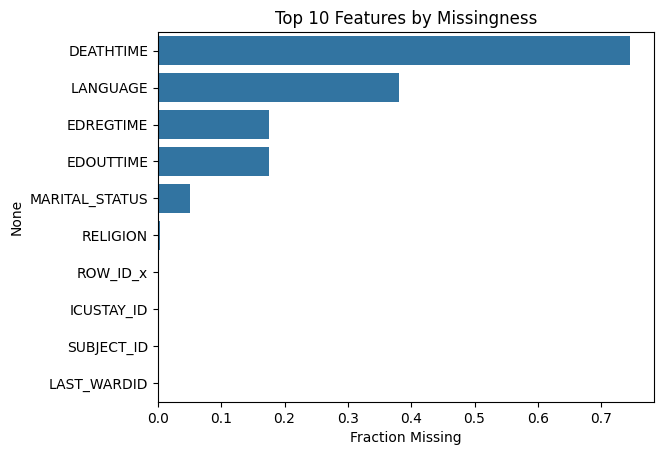

In [ ]:
missing_summary = cohort.isnull().mean().sort_values(ascending=False)
sns.barplot(x=missing_summary.head(10).values, y=missing_summary.head(10).index)
plt.title("Top 10 Features by Missingness")
plt.xlabel("Fraction Missing")
plt.show()

This barplot depicts the differences in mortality rates between sepsis-only groups and the sepsis and cardiac arrest group.

Text(0.5, 1.0, 'Mortality Rate: Sepsis vs Sepsis+Arrest')

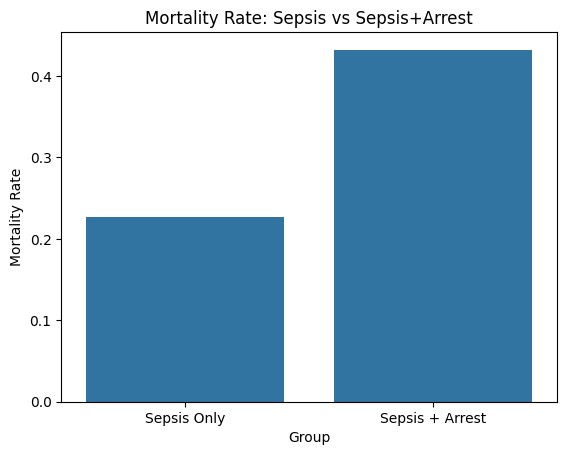

In [ ]:
# Mortality rate comparison
mortality_data = pd.DataFrame({
    'Group': ['Sepsis Only', 'Sepsis + Arrest'],
    'Mortality Rate': [
        sepsis_only['DEATHTIME'].notna().mean(),
        sepsis_with_arrest['DEATHTIME'].notna().mean()
    ]
})
sns.barplot(data=mortality_data, x='Group', y='Mortality Rate')
plt.title("Mortality Rate: Sepsis vs Sepsis+Arrest")

Here we explore the trends in the type of ICU units and the relationships each unit type has with the amount of sepsis/cardiac arrest patients received.

Text(0.5, 0, 'Number of Patients')

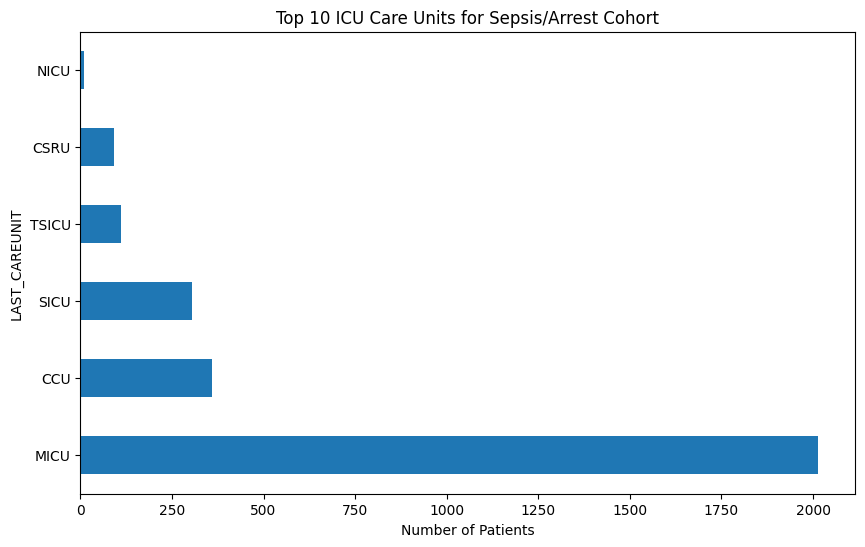

In [ ]:
# Which ICU units have most sepsis/arrest cases?
plt.figure(figsize=(10, 6))
cohort['LAST_CAREUNIT'].value_counts().head(10).plot(kind='barh')
plt.title("Top 10 ICU Care Units for Sepsis/Arrest Cohort")
plt.xlabel("Number of Patients")


This cross tabulation table shows the relationship between the type of admission for the patient and their corresponding mortality rates with the proportion of survivals and deaths for each type.



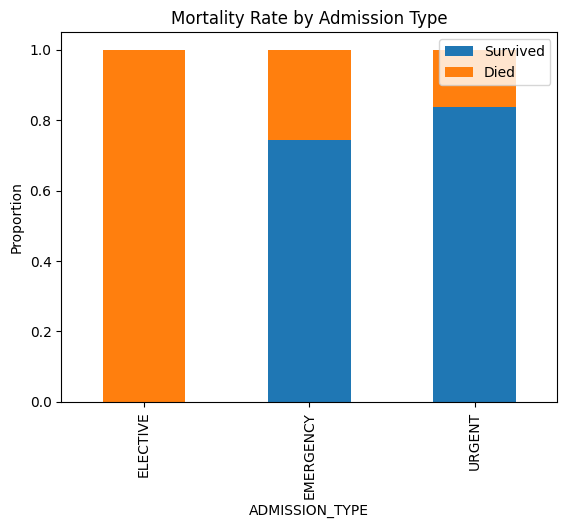

In [ ]:
# Cross-tabulation of admission type and mortality
pd.crosstab(cohort['ADMISSION_TYPE'],
            cohort['DEATHTIME'].notna(),
            normalize='index').plot(kind='bar', stacked=True)
plt.title("Mortality Rate by Admission Type")
plt.ylabel("Proportion")
plt.legend(['Survived', 'Died'])

Here we have a correlation heat map that reveals minimal correlations between multiple variables through a correlation matrix. However, it is important to note that **since correlation matrixes only look at linear relationship, this model may not fully capture the complex non-linear interactions** that might impact how cardiac arrests outcomes. Therefore, future modeling approaches **may require more sophisticated models (i.e random forests, neural networks, etc.)**



Text(0.5, 1.0, 'Correlation Between Numerical Features')

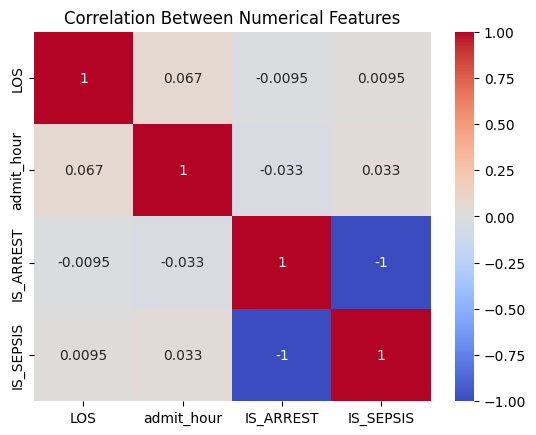

In [ ]:
numerical_cols = ['LOS', 'admit_hour', 'IS_ARREST', 'IS_SEPSIS']  # Add more as you engineer features
correlation_matrix = cohort[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Between Numerical Features")


#Questions for reviewers

1. Is the lead-time (6 hours) justified in light of the data limitations (for example, vitals/labs frequency, documentation delays)?

2. In what way do we acknowledge possible biases in our conclusions? Is there a measurable way to show how those biases might affect our findings?

3. Does our study outline how the model could be deployed or evaluated in a practical environment (for example, real-time ICU monitoring or integration into electronic health record systems)?

.

.

.

.

.


.

.
.

.

.

.

.


.
.

.

.

.
.



.